<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/MonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IMonkeyPFCSaccadeStudies/blob/master/StudyLocationRule/Analysis/04_analyze_target_CNN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Macaque PFC Microelectrode Spike Rates - Convolutional Neural Networks Using AutoEncoder

## Setup

### Environment Setup
Run the cells in this section to configure the local or Google Colab environments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys

try:
    from google.colab import files
    %tensorflow_version 2.x  # Only on colab
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
    
    !pip install git+https://github.com/SachsLab/indl.git
    
    if Path.cwd().stem == 'MonkeyPFCSaccadeStudies':
        os.chdir(Path.cwd().parent)

    if not (Path.cwd() / 'MonkeyPFCSaccadeStudies').is_dir():
        !git clone --single-branch --recursive https://github.com/SachsLab/MonkeyPFCSaccadeStudies.git
        sys.path.append(str(Path.cwd() / 'MonkeyPFCSaccadeStudies'))
    os.chdir('MonkeyPFCSaccadeStudies')
    
    !pip install -q kaggle
    !pip install -U scikit-learn
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    
    # chdir to MonkeyPFCSaccadeStudies
    if Path.cwd().stem == 'Analysis':
        os.chdir(Path.cwd().parent.parent)
    
    # Add indl repository to path.
    # Eventually this should already be pip installed, but it's still under heavy development so this is easier for now.
    check_dir = Path.cwd()
    while not (check_dir / 'Tools').is_dir():
        check_dir = check_dir / '..'
    indl_path = check_dir / 'Tools' / 'Neurophys' / 'indl'
    sys.path.append(str(indl_path))
    
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    
    IN_COLAB = False

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import matplotlib.pyplot as plt
from indl.display import turbo_cmap

In [4]:
# Configure plotting defaults.
if IN_COLAB:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

### Download data if necessary

In [5]:
if IN_COLAB:
    data_path = Path.cwd() / 'data' / 'monkey_pfc' / 'converted'
else:
    data_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed'

if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


### Prepare to load data

We will use a custom function load_macaque_pfc to load the data into memory.

There are 4 different strings to be passed to the import x_chunk argument:
* 'analogsignals' - if present. Returns 1 kHz LFPs
* 'gaze' - Returns 2-channel gaze data.
* 'spikerates' - Returns smoothed spikerates
* 'spiketrains'

The y_type argument can be
* 'pair and choice' - returns Y as np.array of (target_pair, choice_within_pair)
* 'encoded input' - returns Y as np.array of shape (n_samples, 10) (explained below)
* 'replace with column name' - returns Y as a vector of per-trial values. e.g., 'sacClass'

The actual data we load depends on the particular analysis.

In [6]:
from misc.misc import load_macaque_pfc, sess_infos

load_kwargs = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': True,
    'y_type': 'sacClass',  # Integer 0:7 for 8 different targets.
    'samples_last': True  # Our EEGNet blocks expect time-samples in the last dimension.
}

## Autoencoder of spike rates

### Load Data

Load the per-trial spikerates and saccadeClass (0:7)

In [7]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
print(f"\nImporting session {sess_id}")
X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
Y_class = tf.keras.utils.to_categorical(Y_class, num_classes=8)


Importing session sra3_1_j_050_00+
Found 663 trials, 207 timestamps(-0.25 to 1.81 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (663, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


### Create Model

Our model objective is to encode the timeseries segments into a latent variable, then decode the original timeseries segments from the latent variable.

Let's start with a function to make the model:

In [65]:
from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
import math


@check_inputs
def make_model(
        _input,
        F1=8, kernLength=25, F1_kern_reg=None,
        D=2, D_pooling=4,
        F2=8, F2_kernLength=16,
        F2_pooling=8,
        dropoutRate=0.25,
        activation='elu',
        l1_reg=0.000, l2_reg=0.000,
        norm_rate=0.25,
        latent_dim=16,
        return_model=True
    ):
    
    if F1_kern_reg is None:
        F1_kern_reg = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    elif isinstance(F1_kern_reg, str) and F1_kern_reg == 'kern_length_regu':
        F1_kern_reg = KernelLengthRegularizer((1, kernLength),
                                              window_scale=1e-4,
                                              window_func='poly',
                                              poly_exp=2,
                                              threshold=0.0015)
        
    prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(latent_dim), scale=1),
                                          reinterpreted_batch_ndims=1)
        
    if False:
        # EEGNetEnc 
        _y = parts.EEGNetEnc(_input,
                             F1=F1,
                             F1_kernLength=kernLength,
                             F1_kern_reg=F1_kern_reg,
                             D=D,
                             D_pooling=D_pooling,
                             F2=F2,
                             F2_pooling=F2_pooling,
                             F2_kernLength=F2_kernLength,
                             dropoutRate=dropoutRate,
                             activation=activation,
                             l1_reg=l1_reg, l2_reg=l2_reg)

        # Restore time-dimension that was stripped out by EEGNetEnc
        n_times_after_conv = _input.shape.as_list()[2] // D_pooling // F2_pooling
        _y = layers.Reshape((1, n_times_after_conv, F2))(_y)

        mv_distr_dim = tfp.layers.MultivariateNormalTriL.params_size(latent_dim)
        _y = parts.Bottleneck(_y, latent_dim=mv_distr_dim, dropoutRate=0, activation=None)
        _y = tfp.layers.MultivariateNormalTriL(latent_dim,
                                           activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)
                                          )(_y)

        # Undo bottleneck
        _x = parts.UndoBottleneck(_y, target_shape=(1, n_times_after_conv, F2),
                                  dropoutRate=dropoutRate,
                                  activation=activation, return_model=False)

        _x = parts.EEGNetDecodeA(_x, F1=F1, D=D,
                                 F2_kernLength=F2_kernLength,
                                 F2_pooling=F2_pooling,
                                 activation=activation,
                                 dropoutRate=dropoutRate,
                                 l1_reg=l1_reg, l2_reg=l2_reg,
                                 return_model=False)

        n_times_after_DecA = _input.shape.as_list()[2] // D_pooling // F2_pooling * F2_pooling
        targ_time_dim = _input.shape.as_list()[2] // D_pooling
        total_padding = max(0, targ_time_dim - n_times_after_DecA)
        padding_tuple = (int(math.ceil(total_padding / 2)), total_padding // 2)
        _x = layers.ZeroPadding2D((0, padding_tuple))(_x)

        _x = parts.EEGNetDecodeB(_x, num_chans=_input.shape.as_list()[1],
                                 D_pooling=D_pooling,
                                 F1=F1, F1_kernLength=kernLength,
                                 activation=activation,
                                 dropoutRate=dropoutRate,
                                 l1_reg=l1_reg, l2_reg=l2_reg,
                                 return_model=False)

        n_times_after_DecB = _input.shape.as_list()[2] // D_pooling * D_pooling
        total_padding = max(0, _input.shape.as_list()[2] - n_times_after_DecB)
        padding_tuple = (int(math.ceil(total_padding / 2)), total_padding // 2)
        _x = layers.ZeroPadding2D((0, padding_tuple))(_x)

        # Final Conv
        _x = layers.Conv2D(1, (1, kernLength), padding='same',
                           kernel_regularizer=F1_kern_reg)(_x)
        _x = layers.Activation(activation)(_x)
        _x = layers.BatchNormalization(axis=-1)(_x)
        _x = layers.Dropout(dropoutRate)(_x)

        _x = layers.Reshape(target_shape=_input.shape.as_list()[1:])(_x)
        
    else:
        
        depth_regu = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        
        input_shape = _input.shape.as_list()
        num_chans = input_shape[1]
        num_samps = input_shape[2]
        
        # Usually the filter dimension does not exist so let's add that.
        if len(input_shape) < 4:
            input_shape = input_shape + [1]
        # input_shape[2] = -1  # Comment out during debug
        _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.
        
        _y = layers.Conv2D(F1, (1, kernLength),
                           padding='same',
                           kernel_regularizer=F1_kern_reg,
                           activation=activation,
                           # use_bias=False
                           )(_y)
        
        _y = layers.Conv2D(F1, (1, kernLength),
                           strides=(1, D_pooling),
                           padding='same',
                           kernel_regularizer=F1_kern_reg,
                           activation=activation)(_y)
        
        # Smooth in the time-dimension
#         _y = layers.AveragePooling2D((1, D_pooling))(_y)
#         _y = layers.Dropout(dropoutRate)(_y)
        
        _y = layers.Conv2D(F2, (1, F2_kernLength),
                           padding='same',
                           activation=activation)(_y)
        _y = layers.Conv2D(F2, (1, F2_kernLength),
                           strides=(1, F2_pooling),
                           padding='same',
                           activation=activation)(_y)
        
#         _y = layers.AveragePooling2D((1, F2_pooling))(_y)
#         _y = layers.Dropout(dropoutRate)(_y)
        
#         _y = layers.DepthwiseConv2D((num_chans, 1),
#                                     padding='valid',
#                                     activation=activation,
                                    # use_bias=False,
#                                     depth_multiplier=D,
#                                     depthwise_regularizer=depth_regu,
#                                     depthwise_constraint=max_norm(1.))(_y)
#         _y = layers.Conv2D(D*F2, (1, F2_kernLength),
#                        padding='same',
#                        activation=activation)(_y)
#         _y = layers.MaxPooling2D((1, F2_pooling))(_y)
#         _y = layers.Dropout(dropoutRate)(_y)

        _y = layers.Conv2D(D*F2, (num_chans, 4),
                           padding='valid',
                           activation=activation)(_y)
        
        _y = layers.Flatten()(_y)
        mv_distr_dim = tfp.layers.MultivariateNormalTriL.params_size(latent_dim)
        
        _y = layers.Dense(mv_distr_dim, activation=None)(_y)
        
        _y = tfp.layers.MultivariateNormalTriL(latent_dim,
                                           activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)
                                          )(_y)
        
        _x = _y
        
        _x = layers.Reshape([1, 1, latent_dim])(_x)
        
        _x = layers.Dense(mv_distr_dim, activation=activation)(_x)
        
        _x = layers.Conv2DTranspose(F2, (num_chans, 4), strides=1,
                                    padding='valid', activation=activation)(_x)
        
        _x = layers.Conv2DTranspose(F2, (1, F2_kernLength), strides=1,
                                    padding='same', activation=activation)(_x)
        _x = layers.Conv2DTranspose(F2, (1, F2_kernLength), strides=(1, F2_pooling),
                                    padding='same', activation=activation)(_x)
        
        _x = layers.Conv2DTranspose(F1, (1, kernLength), strides=(1, 1),
                                    padding='same', activation=activation)(_x)
        _x = layers.Conv2DTranspose(F1, (1, kernLength), strides=(1, D_pooling),
                                    padding='same', activation=activation)(_x)
        
        _x = layers.Conv2DTranspose(F1, (1, kernLength), strides=1,
                                    padding='same', activation=activation)(_x)
        
        _x = layers.Conv2D(filters=2, kernel_size=(1, kernLength), strides=1,
                           padding='same', activation=None)(_x)
        
       
        if False:

            _x = layers.Conv2DTranspose(D*F2, (1, F2_kernLength),
                                        strides=(1, F2_pooling),
                                        activation=activation,
                                        padding='same')(_x)
            _x = layers.BatchNormalization()(_x)
            _x = layers.Dropout(dropoutRate)(_x)

            _x = layers.UpSampling2D((num_chans, 1))(_x)
            _x = layers.DepthwiseConv2D((num_chans, 1), padding='same',
                                       depth_multiplier=1)(_x)

            _x = layers.Conv2DTranspose(F2, (1, F2_kernLength),
                                        strides=(1, F2_pooling),
                                        activation=activation,
                                        padding='same')(_x)
            _x = layers.BatchNormalization()(_x)
            _x = layers.Dropout(dropoutRate)(_x)


            _x = layers.Conv2DTranspose(F1, (1, kernLength),
                                        strides=(1, D_pooling),
                                        activation=activation,
                                        padding='same')(_x)

            _x = layers.Conv2D(2, (1, num_samps), padding='same')(_x)
        
        _x = layers.Flatten()(_x)
        
        _x = tfp.layers.IndependentNormal((num_chans, num_samps))(_x)        
    
    if return_model:
        return tf.keras.models.Model(inputs=[_input], outputs=[_x])
    else:
        return _x

Parameterize the model and preview the model.
 

In [69]:
from indl.data.augmentations import random_slice
from functools import partial


model_kwargs = dict(
    F1=16, kernLength=25, F1_kern_reg=None,
    D=2, D_pooling=4,
    F2=32, F2_kernLength=16,
    F2_pooling=4,
    dropoutRate=0.30,
    activation='selu',
    l1_reg=0.000, l2_reg=0.003,
    norm_rate=0.25,
    latent_dim=8
)

n_min_times = model_kwargs['F2_kernLength'] * model_kwargs['D_pooling']
max_offset = X_rates.shape[-1] - n_min_times
p_random_slice = partial(random_slice, max_offset=max_offset)

In [70]:
def rates2dataset(X, is_train=True, batch_size=16):
    temp_ds = tf.data.Dataset.from_tensor_slices((X, X))
    
    # cast data types to GPU-friendly types.
    temp_ds = temp_ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    
    # augmentations (random slicing?)
    temp_ds = temp_ds.map(p_random_slice)

    if is_train:
        temp_ds = temp_ds.shuffle(X.shape[0] + 1)
        
    temp_ds = temp_ds.batch(batch_size, drop_remainder=is_train)
    
    return temp_ds


In [71]:
tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

temp_ds = rates2dataset(X_rates)

model = make_model(
    temp_ds.element_spec[0],
    **model_kwargs
)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_fun = lambda x, rv_x: -rv_x.log_prob(x)
model.compile(optimizer=optim, loss=loss_fun)
model.summary()
if False:
    tf.keras.utils.plot_model(
        model,
        to_file='model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 64)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 64, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 16, 16)        6416      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 16, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 4, 32)         16416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          262208

### Training loop


In [72]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
BATCH_SIZE = 8
EPOCHS = 80


def get_hists_ae(sess_id, verbose=1):
    print(f"Processing session {sess_id}...")
    X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []

    for trn, vld in splitter.split(X_rates, Y_class):
        # Quick terminate for debugging
        if split_ix > 0:
            break
            
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        
        ds_train = rates2dataset(X_rates[trn], is_train=True, batch_size=BATCH_SIZE)
        ds_valid = rates2dataset(X_rates[vld], is_train=False, batch_size=BATCH_SIZE)
        
        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(
            ds_train.element_spec[0],
            **model_kwargs
        )
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_fun = lambda x, rv_x: -rv_x.log_prob(x)
        model.compile(optimizer=optim, loss=loss_fun)
        
        best_model_path = f'ratesAE_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                save_weights_only=True,  # Necessary for tf probabilistic
                monitor='val_loss',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
    
    return history
        

Test training on one session.

Processing session sra3_1_j_050_00+...
Found 663 trials, 207 timestamps(-0.25 to 1.81 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (663, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
Train for 73 steps, validate for 9 steps
Epoch 1/80

Epoch 00001: val_loss improved from inf to 2801.90367, saving model to ratesAE_sra3_1_j_050_00+_split0.h5
73/73 - 5s - loss: 3115.4750 - val_loss: 2801.9037
Epoch 2/80

Epoch 00002: val_loss improved from 2801.90367 to 2553.57848, saving model to ratesAE_sra3_1_j_050_00+_split0.h5
73/73 - 3s - loss: 2658.0013 - val_loss: 2553.5785
Epoch 3/80

Epoch 00003: val_loss improved from 2553.57848 to 2444.43205, saving model to ratesAE_sra3_1_j_050_00+_split0.h5
73/73 - 3s - loss: 2496.6832 - val_loss: 2444.4320
Epoch 4/80

Epoch 00004: val_loss improved from 2444.43205 to 2425.07007, saving model to ratesAE_sra3_1_j_050_00+_split0.h5
73/73 - 3s - loss: 2444.39

Epoch 60/80

Epoch 00060: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 2031.2776 - val_loss: 2220.7432
Epoch 61/80

Epoch 00061: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 1974.2421 - val_loss: 2299.8033
Epoch 62/80

Epoch 00062: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 1962.2740 - val_loss: 2234.7224
Epoch 63/80

Epoch 00063: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 1961.9982 - val_loss: 2232.3644
Epoch 64/80

Epoch 00064: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 1976.1065 - val_loss: 2249.9511
Epoch 65/80

Epoch 00065: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 1976.2942 - val_loss: 2367.4053
Epoch 66/80

Epoch 00066: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 2002.3389 - val_loss: 2226.9445
Epoch 67/80

Epoch 00067: val_loss did not improve from 2216.39220
73/73 - 3s - loss: 2035.3576 - val_loss: 2392.2724
Epoch 68/80

Epoch 00068: val_loss did not improve from 

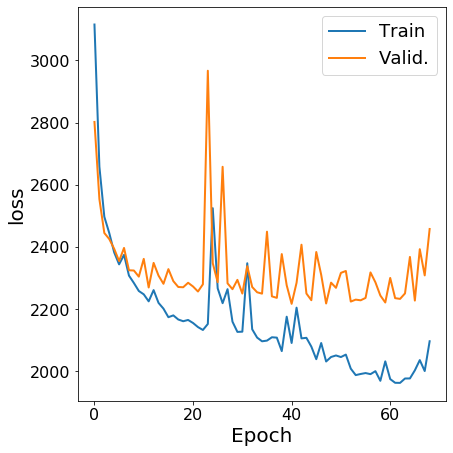

In [73]:
from indl.metrics import quickplot_history

history = get_hists_ae(sess_infos[1]['exp_code'], verbose=2)
quickplot_history(history)

In [74]:
# plot a few samples
from tensorflow.keras.models import load_model


if False:
    sess_id = sess_infos[1]['exp_code']
    best_model_path = f'ratesAE_{sess_id}_split{0}.h5'
    tf.keras.backend.clear_session()
    model = make_model(
                temp_ds.element_spec[0],
                **model_kwargs
            )
model.load_weights(best_model_path)

X_rates, Y_class, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
tmp = X_rates[:, :, max_offset // 2 : max_offset // 2 + n_min_times]
preds = model(tmp)

W0121 21:14:44.754858 140375979087680 base_layer.py:1790] Layer reshape is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Found 663 trials, 207 timestamps(-0.25 to 1.81 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (663, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])


(663, 32, 64) (663, 32, 64)


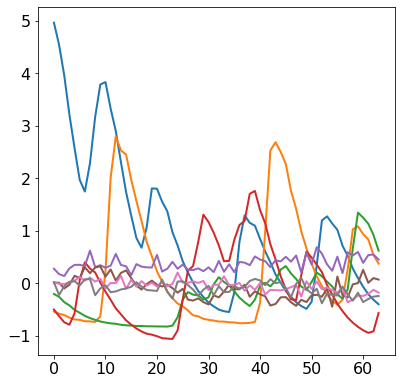

In [77]:
print(tmp.shape, preds.shape)

plt.plot(tmp[0, :4, :].T)
plt.plot(np.mean(preds.sample(100).numpy(), axis=0)[0, :4, :].T)

### Training and evaluation - per session

Note that using verbose=0 will suppress most of the log information. Progress indicators might only be updated once every few minutes, depending on the number of epochs and the amount of time it takes to process a session.

In [14]:
hists = []
for sess_info in sess_infos:
    _hist = get_hists_ae(sess_info['exp_code'], verbose=0)
    hists.append(_hist)

Processing session sra3_2_j_037_00+03...
Found 160 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (160, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_2_j_037_00+03 overall accuracy: 72.5%
Processing session sra3_1_j_050_00+...
Found 285 trials, 171 timestamps(-0.25 to 1.45 at 100.0 Hz), 32 channels
Returning Y as sacClass with shape (285, 1).
Axis info has: dict_keys(['instance_data', 'instance_times', 'fs', 'timestamps', 'channel_names', 'channel_locs'])
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Session sra3_1_j_050_00+ overall accuracy: 87.71929824561404%
Processing session sra3_1_j_051_00+...


## TODO
   
1. Use Capsules
1. Replace deeper conv layers with LSTM
1. If using autoencoder, make sure AE on its own can reconstruct input reasonably well.
1. Better model inspection (put code in indl)


Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~81% in two datasets. Using the EEGNet CNN, we achieve 74% and 85%. The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [ ]:
# Load the 'best' model from disk.
tf.keras.backend.clear_session()
from tensorflow.keras.models import load_model
model = load_model(datadir / 'models' / (SESS_ID + '_model_best_all.h5'))
# model.summary()

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

https://distill.pub/2016/misread-tsne/

From [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

>t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

We will compare the t-SNE projections of the outputs to the projections of the inputs.
However, the raw spiketrains do not decompose to very well so for inputs we will use spikerates that are previously derived from the spike trains convolved with a gaussian kernel (sigma=50 msec).

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))
class_colors = np.array([next(colour_codes) for _ in range(10)])
# class_colors = np.array(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])
tbs = 30  # tsne batch size

TEST_PERPLEXITY = 20  # 10, 30

def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=class_colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title + ' (Ppx: {})'.format(perplexity))
    ax = plt.gca()

In [ ]:
fig = plt.figure(figsize=(12, 12))

# First plot a t-SNE on the input data. Precede TSNE with a PCA.
pca = PCA(n_components=50)
pca_values = pca.fit_transform(rates_X.reshape([-1, np.prod(rates_X.shape[1:])]))
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 1)
plot_tsne(tsne_values, rates_Y.ravel()+1, TEST_PERPLEXITY, title='Input Rates')

# Let's create a version of our CNN model that goes from input to the bottleneck layer
truncated_model = tf.keras.Model(model.input, [model.layers[7].output,
                                               model.get_layer('latent').output,
                                               model.layers[-6].output])
rates = []
latents = []
recon_rates = []
for start_ix in range(0, X.shape[0], tbs):
    temp = X[start_ix:start_ix+tbs, MAX_OFFSET:, :].astype(np.float32)[:, :, :, None]
    _rates, _latents, _recon_rates = truncated_model(temp)
    rates.append(_rates)
    latents.append(_latents)
    recon_rates.append(_recon_rates)
    
rates = tf.concat(rates, 0).numpy()
latents = tf.concat(latents, 0).numpy()
recon_rates = tf.concat(recon_rates, 0).numpy()
tf.keras.backend.clear_session()

flattened_rates = rates.reshape([-1, np.prod(rates.shape[1:])])
flattened_latents = latents.reshape([-1, np.prod(latents.shape[1:])])
flattened_recon_rates = recon_rates.reshape([-1, np.prod(recon_rates.shape[1:])])

# Model Rates
pca = PCA(n_components=50)
pca_values = pca.fit_transform(flattened_rates)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(pca_values)
plt.subplot(2, 2, 2)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Features')

# Model Latents
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_latents)
plt.subplot(2, 2, 3)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Model Latents')

# Recon Rates
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY)
tsne_values = tsne_model.fit_transform(flattened_recon_rates)
plt.subplot(2, 2, 4)
plot_tsne(tsne_values, Y.ravel()+1, TEST_PERPLEXITY, title='Recon Features')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_tSNE.png')))

t-SNE on the untransformed data shows two different clusters for blue/magenta trial pairs.
These probably came at two different blocks of time, between which there was a change in the neural activations.
After transforming the data, these classes are grouped together.

In [ ]:
fig = plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
chan_ix = 31  # 4
_X = rates_X
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Smoothed Rates')

plt.subplot(2, 2, 2)
chan_ix = -4  # 4
_X = rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Convolved Spikes')

plt.subplot(2, 2, 4)
chan_ix = -4  # 4
_X = recon_rates
for class_ix in range(8):
    b_class = rates_Y[:, 0] == class_ix
    mean_rates = np.squeeze(np.mean(_X[b_class], axis=0))
    plt.plot(mean_rates[:, chan_ix], color=class_colors[class_ix])
plt.title('Recon Features')

plt.tight_layout()

fig.savefig(str(datadir / (SESS_ID + '_example_rates.png')))

In [ ]:
import tensortools as tt

U = tt.cp_als(np.squeeze(rates_X), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

In [ ]:
U = tt.cp_als(np.squeeze(rates), rank=3, verbose=True)
fig, ax, po = tt.plot_factors(U.factors, plots=['scatter', 'line', 'bar'], figsize=(9, 6))

### First convolutional layers
The first pair of convolutional layers are simply performing time-domain convolutions on the spike trains.
Whereas a typically signal processing pipeline will apply a gaussian, exponentional, or gamma kernel convolution,
here we train the convolution kernels directly. There are separate "short" kernels and "long" kernels.

In [ ]:
import scipy.signal

fig = plt.figure(figsize=(12, 12))
t = ax_info['timestamps']

x_ranges = [[-0.02, 0.02], [-0.2, 0.2]]
y_steps = [1.0, 0.5]

impulse = np.zeros_like(t)
impulse[np.argmin(np.abs(t))] = 1.0

step = np.zeros_like(t)
step[np.argmin(np.abs(t)):] = 1.0

for s_l in range(2):
    filters = np.squeeze(model.layers[1 + s_l].get_weights()[0])

    # Impulse response
    plt.subplot(2, 3, 1 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
        plt.plot(t, imp_conv - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Impulse Response')

    # Step response
    plt.subplot(2, 3, 2 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        step_response = scipy.signal.convolve(step, filt_coeff, 'same')
        plt.plot(t, step_response - y_steps[s_l]*filt_ix)
    plt.xlim(x_ranges[s_l])
    plt.xlabel('Time (s)')
    plt.title('Step Response')

    plt.subplot(2, 3, 3 + 3*s_l)
    for filt_ix, filt_coeff in enumerate(filters.T):
        f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
        plt.plot(f, np.abs(resp) - filt_ix)
    plt.xlabel('Frequency (Hz)')
    plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

In [ ]:
LAYER_IX = 4
spatial_filter = np.squeeze(model.layers[LAYER_IX].get_weights()[0])
D = spatial_filter.shape[-1]
sp_cols = int(np.ceil(np.sqrt(D + 2)))
sp_rows = int(np.ceil((D + 2) / sp_cols))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12))
for depth_ix in range(D):
    plt.subplot(sp_rows, sp_cols, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin, cmap=turbo_cmap)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()

sum_abs_weight = np.sum(np.sum(np.abs(spatial_filter), axis=1), axis=-1)
plt.subplot(sp_rows, sp_cols, D + 1)
plt.hist(sum_abs_weight, 20)
plt.xlabel('Sum Abs Weight')
plt.ylabel('Count')
plt.title('Chan Sum Abs. Weight')

plt.subplot(sp_rows, sp_cols, D + 2)
plt.bar(np.arange(spatial_filter.shape[0]), sum_abs_weight)
plt.xlabel('Channel ID')
plt.ylabel('Sum Abs Weight')

plt.tight_layout()
plt.show()

fig.savefig(str(datadir / (SESS_ID + '_CNN_SpatFilts.png')))

ch_ids = np.argsort(sum_abs_weight)[::-1]  # channel_ids sorted by weight, descending

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

## Filter Activation-Maximizing Inputs

One useful way to understand what a convolutional layer is doing, especially for deeper layers that are combining abstract features, is to visualize an input that would maximize activation of a filter(s) within the layer.

Remembering back to the step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function for a given set of _inputs_. Now we know the weights but we want to find the inputs that _maximize_ the activation (a.k.a. output) of a filter. We're going to use the same loss-minimization training framework, but instead of calculating a 'loss', we will calculate the mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to maximize output (i.e., step the input up the gradients).

In [ ]:
from tensorflow.keras import backend as K

def plot_layer(layer_ix, max_filts=None, n_steps=100):
    in_shape = [1] + model.input.shape.as_list()[1:]
    
    layer_output = model.layers[layer_ix].output
    n_filts = layer_output.shape[-1]
    filt_ids = np.arange(n_filts)
    if (max_filts is not None) and (len(filt_ids) > max_filts):
        filt_ids = filt_ids[np.argsort(np.random.rand(n_filts))][:max_filts]
    
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    sp_cols = int(np.ceil(np.sqrt(len(filt_ids))))
    sp_rows = int(np.ceil(len(filt_ids) / sp_cols))
    
    filt_slice = [np.s_[:] for _ in range(K.ndim(layer_output))]
    
    for ix, filt_ix in enumerate(filt_ids):
        input_data = tf.convert_to_tensor(np.random.randn(*in_shape).astype(np.float32))
        if layer_ix > (len(model.layers) - 3):
            # model.layers[layer_ix].activation == tf.keras.activations.softmax:
            max_model = tf.keras.Model(model.input, layer_output)
            non_targ_id = tf.constant(np.setdiff1d(np.arange(layer_output.shape[-1], dtype=int), filt_ix))
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    targ_act = filter_act[0, filt_ix]
                    nontarg_act = K.mean(tf.gather(filter_act, non_targ_id, axis=-1))
                    loss_value = targ_act - nontarg_act
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        else:
            filt_slice[-1] = filt_ix
            max_model = tf.keras.Model(model.input, layer_output[tuple(filt_slice)])
            for step_ix in range(n_steps):
                with tf.GradientTape() as tape:
                    tape.watch(input_data)
                    filter_act = max_model(input_data)
                    loss_value = K.mean(filter_act)
                grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
                # Normalize gradients
                grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
                input_data += grads
        input_data = np.squeeze(input_data)

        plt.subplot(sp_rows, sp_cols, ix + 1)
        plt.plot(t[MAX_OFFSET:], input_data[:, ch_ids[:4]])
        plt.xlabel('Time After Target Onset (s)')
        plt.ylabel('Filter {}'.format(filt_ix))
        plt.title('Output {:.2f}'.format(loss_value.numpy()))
        for xx in [0, 0.25, 1.25]:
            plt.axvline(xx, color='k', linestyle='--')
        
    plt.tight_layout()

In [ ]:
# 4 is DepthwiseConv2D, 9 is SeparableConv2D
plot_layer(9, max_filts=9)

### Class Maximizing Inputs
If we extend our reasoning from filter activations down to the next-to-last layer (15), and we choose a 'loss' that maximizes one class, we can plot maximization signals for each of the 8 output classes. If we were to do the same on the final Softmax layer (16), the results have a similar shape but are quite noisy because perfect classification is achieved quickly and thus there is no more gradient.

In [ ]:
plot_layer(15, n_steps=100)

## Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
def get_losses_for_class(test_class):
    classes, y = np.unique(Y, return_inverse=True)
    trial_ids = np.where(y == classes.tolist().index(test_class))[0]
    losses_grads = []
    for tr_id in trial_ids:
        input_data = tf.convert_to_tensor(X[tr_id, MAX_OFFSET:, :].astype(np.float32)[None, :, :, None])
        with tf.GradientTape() as tape:
            tape.watch(input_data)
            class_proba = model(input_data)
            loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
        grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
        losses_grads.append((loss_value, grads))
    return losses_grads

In [ ]:
# Plot saliency image for a few trials in a particular class
N_SALIENCY_TRIALS = 3
TEST_CLASS = 5  # -1 to 6
losses_grads = get_losses_for_class(TEST_CLASS)
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
re_ix = np.argsort(loss_vals)
b_class = np.squeeze(Y == TEST_CLASS)
_x = X[b_class, MAX_OFFSET:][re_ix][:N_SALIENCY_TRIALS]
_masks = grad_vals[re_ix][:N_SALIENCY_TRIALS]

fig = plt.figure(figsize=(8, 6), facecolor='white')
for tr_ix in range(N_SALIENCY_TRIALS):
    plt.subplot(N_SALIENCY_TRIALS, 1, tr_ix + 1)
    plt.imshow(_masks[tr_ix].T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    plt.eventplot([np.where(_)[0] for _ in _x[tr_ix].T], colors='k')
    for _t in t0_ix:
        plt.axvline(_t)
plt.xlabel('Sample')
plt.ylabel('Channel ID')
plt.tight_layout()

In [ ]:
# Plot average saliencies for all trials within each class
t = ax_info['timestamps'][MAX_OFFSET:]
t0_ix = [np.argmin(np.abs(t - _)) for _ in [0, 0.25, 1.25]]

fig = plt.figure(figsize=(12, 18), facecolor='white')

for ix, class_id in enumerate(np.unique(Y)):
    losses_grads = get_losses_for_class(class_id)
    loss_vals = [_[0][0].numpy() for _ in losses_grads]
    grad_vals = np.squeeze(np.concatenate([_[1].numpy() for _ in losses_grads], axis=0))
    grad_vals = np.mean(grad_vals, axis=0)
    plot_ix = 2 * ix + 1 * (ix < 4) - 6 * (ix >= 4)
    plt.subplot(4, 2, plot_ix)
    plt.imshow(grad_vals.T, aspect='auto', interpolation='none', vmin=-4, vmax=4, cmap=turbo_cmap)
    for _t in t0_ix:
        plt.axvline(_t)
    plt.title(str(class_id))
    if (ix + 1) % 4 == 0:
        plt.xlabel('Sample')
    if ix < 4:
        plt.ylabel('Channel')
plt.tight_layout()

## Class Activation Maps

Class activation maps (CAM) highlight the parts of the input that contribute most to each classification score. This is similar but different to saliency mapping. Whereas in saliency mapping the losses are back-propagated all the way back to the inputs, in CAM (or [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf)) the per-class scores / losses are propaged backward only to the last convolutional layer. These losses are then used as the weights in a weighted average of the feature map output of the last convolutional layer. If the result is smaller than the input, it is then interpolated to match the input size.

Remember that in image classification the data have width pixels x height pixels x colour depths, but in our neural time-series data we have time samples x 1 x electrodes. We could use CAM on our timeseries data to identify which time points are important for each class but not channels because CAM averages across 'depth'. Time-point importance is unlikely to be informative in this dataset because it is unlikely that the timing of processing visual cues and creating motor plans is class-dependent, especially not at the time scales of the final convolution output (~100 msec).

To get any information about which channels of the input were important, we would have to project the losses back to before the spatial filter layer (`DepthwiseConv2D`).

TODO: Cluster channels based on cross-correlations of per-trial saliency maps.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    k_spike_short = params.get('k_spike_short', 10)
    l_spike_short = params.get('l_spike_short', 22)
    k_spike_long = params.get('k_spike_long', 4)
    l_spike_long = params.get('l_spike_long', 200)
    D = params.get('D', 4)
    downsamp_1 = params.get('downsamp_1', 5)
    n_pointwise_filters = params.get('n_pointwise_filters', 38)
    kern_length_2 = params.get('kern_length_2', 40)
    downsamp_2 = params.get('downsamp_2', 8)
    norm_rate = params.get('norm_rate', 0.3)
    dropout_rate = params.get('dropout_rate', 0.3)
    latent_dim = params.get('latent_dim', 10)
    gamma = params.get('gamma', 1.0)
    window_scale = params.get('window_scale', 1.0)
    l1_reg = params.get('l1_reg', 0.0002)
    l2_reg = params.get('l2_reg', 0.0002)
    epochs = params.get('epochs', 80)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=123)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    tf.keras.backend.clear_session()
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       k_spike_short=k_spike_short, l_spike_short=l_spike_short,
                       k_spike_long=k_spike_long, l_spike_long=l_spike_long,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    max_val_acc = max(history.history['val_accuracy'])
    print("Max validation accuracy with these parameters: {}".format(max_val_acc))
    
    tf.keras.backend.clear_session()
    
    return -max_val_acc

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest

space = {
#     'k_spike_short': scope.int(hp.quniform('k_spike_short', 1, 15, 1)),
#     'l_spike_short': scope.int(hp.quniform('l_spike_short', 8, 50, 2)),
    'k_spike_long': scope.int(hp.quniform('k_spike_long', 1, 15, 1)),
#     'l_spike_long': scope.int(hp.quniform('l_spike_long', 60, 250, 5)),
#     'D': scope.int(hp.quniform('D', 1, 12, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 4, 10, 1)),
#     'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
#     'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 64, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 9, 1)),
#     'norm_rate': hp.uniform('norm_rate', 0., 0.5),
#     'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     '12_reg': hp.loguniform('l1_reg', np.log(0.000001), np.log(1.0)),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(1.0)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
    'latent_dim': scope.int(hp.quniform('latent_dim', 5, 50, 5)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(100)),
    'window_scale': hp.loguniform('window_scale', np.log(1e-4), np.log(100))
}    

trials = Trials()  # object that holds iteration results
#Do optimization
eval_hours = 5.
minutes_per_eval = 2.5
max_evals = int(eval_hours * 60 / minutes_per_eval)
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
print("Best Acc: {}".format(-trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

In [ ]:
def scatterplot_matrix_colored(params_names, params_values, best_losses,
                               alpha=0.3, minmax='min'):
    """Scatterplot colored according to the Z values of the points."""
    import matplotlib
    
    nb_params = len(params_values)
    
    best_losses = np.array(best_losses)
    if minmax == 'min':
        best_trial = np.argmin(best_losses)
    else:
        best_trial = np.argmax(best_losses)
        
    norm = matplotlib.colors.Normalize(vmin=best_losses.min(), vmax=best_losses.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16))
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            axes.axvline(p2[best_trial], color='r', zorder=-1, alpha=0.3)
            axes.axhline(p1[best_trial], color='r', zorder=-1, alpha=0.3)
                
            # Subplot:
            s = axes.scatter(p2, p1, s=30, alpha=alpha,
                             c=best_losses, cmap=turbo_cmap, norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried values in the search space over different params, colored according to best validation loss')
    plt.show()

# Prepare loss values. Maybe transform.
hp_loss = np.array([_['result']['loss'] for _ in trials.trials])
hp_loss = -hp_loss

hp_names = list(space.keys())
hp_vals = [[_['misc']['vals'][key][0] for _ in trials.trials] for key in hp_names]
log_hps = [_ for _ in ['l1_reg', 'l2_reg', 'window_scale', 'gamma'] if _ in hp_names]
for hp_name in log_hps:
    hp_vals[hp_names.index(hp_name)] = np.log10(hp_vals[hp_names.index(hp_name)])

scatterplot_matrix_colored(hp_names, hp_vals, hp_loss, minmax='max',
                           alpha=0.8)
print(np.max(hp_loss))

In [ ]:
# Grouped bar plots of manually-input data.
monkey_names = ['M', 'JL']
data_types = ['LR\nBaseline', 'LR\nTargets', 'LR\nFull', 'EEGNet\nFull', 'LSTM\nFull', 'EEGNet\n& AE']
accuracies = [[30.2, 43.4, 61.2, 72.3, 76.1, 69.9],[36.8, 46.5, 81.1, 85.4, 85.5, 82.5]]

ind = np.arange(len(data_types))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 8))
for m_ix, m_name in enumerate(monkey_names):
    ax.bar(ind - width/2 + m_ix * width, accuracies[m_ix], width, label=m_name)

ax.set_ylabel('Accuracies (%)')
ax.set_ylim([0, 100])
ax.set_title('Target Prediction by Session and Model')
ax.set_xticks(ind)
ax.set_xticklabels(data_types)
ax.legend()
plt.tight_layout()

fig.savefig(str(datadir / ('Acc_Bars.png')))